# Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.

In [15]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import statistics as stat
from io import StringIO
import nltk
import sklearn

Tout d'abord, on sélectionne la catégorie de produit à étudier:

In [206]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Catégorie de produit à étudier")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [207]:
if(not(os.path.isfile(dropdown.value[:-3]))):
    inputFile = gzip.open(dropdown.value, 'rb')
    outputFile = open(dropdown.value[:-3], 'wb')
    outputFile.write(inputFile.read())
    inputFile.close()
    outputFile.close()

On la transforme en Pandas DataFrame 

In [208]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

In [16]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0006428320,"[0, 0]",3,The portfolio is fine except for the fact that...,"03 11, 2014",A1YS9MDZP93857,John Taylor,Parts missing,1394496000
1,0014072149,"[0, 0]",5,If you are a serious violin student on a budge...,"06 6, 2013",A3TS466QBAWB9D,Silver Pencil,"Perform it with a friend, today!",1370476800
2,0041291905,"[0, 0]",5,This is and excellent edition and perfectly tr...,"10 14, 2013",A3BUDYITWUSIS7,joyce gabriel cornett,Vivalldi's Four Seasons,1381708800
3,0041913574,"[0, 0]",5,Perfect for someone who is an opera fan or a w...,"09 23, 2010",A19K10Z0D2NTZK,TexasCowboy,Full score: voice and orchestra,1285200000
4,0201891859,"[0, 1]",1,How many Nocturnes does it contain? All of the...,"10 17, 2012",A14X336IB4JD89,dfjm53,Unable to determine contents,1350432000


# Séparation Training and Validation sets

Avant de commencer toute analyse ou modélisation, il faut séparer l'échantillon d'entrainement et l'échantillon de validation. On procède comme suit:

In [17]:
from sklearn.cross_validation import train_test_split
y = df["overall"]
X = df.drop("overall",axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
df_train=X.iloc[X_train] # return dataframe train
df_test=X.iloc[X_test] # return dataframe test
df_test.head()

,asin,helpful,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
41079,B0002DUQ04,"[3, 4]",THESE STRING ARE GREAT. ERNIE BALL ALWAYS PRO...,"05 21, 2009",AJ42WAM97FE9J,Seamus McEast,EAST,1242864000
326679,B003U4RXTY,"[3, 3]","Great distortion, fantastic clean, and sustain...","05 31, 2011",AA9TRYXYOBNW,Jason,Can you say awesome guitar?,1306800000
341978,B004393VBY,"[3, 3]",I bought this album to continue with my MSI/Le...,"12 13, 2010",A92RTEIAIJ9C3,T. Skaggs,Jimmy and Steve are good buddies,1292198400
8706,B00004XQ83,"[0, 0]","Great music in general and for a soundtrack, i...","03 5, 2014",A29NC1ZLND4KKX,Anne,Fabulous soundtrack,1393977600
379781,B0055E8792,"[1, 2]",Was looking around for a guitar with some sort...,"08 13, 2012",AE3XGQKAKH6GI,Doug,Awesome!!!,1344816000


# Analyse descriptive [Attention ne prend pas encore en compte la séparation ci dessus]

Regardons la structure de la table:

In [211]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0006428320,"[0, 0]",3,The portfolio is fine except for the fact that...,"03 11, 2014",A1YS9MDZP93857,John Taylor,Parts missing,1394496000
1,0014072149,"[0, 0]",5,If you are a serious violin student on a budge...,"06 6, 2013",A3TS466QBAWB9D,Silver Pencil,"Perform it with a friend, today!",1370476800
2,0041291905,"[0, 0]",5,This is and excellent edition and perfectly tr...,"10 14, 2013",A3BUDYITWUSIS7,joyce gabriel cornett,Vivalldi's Four Seasons,1381708800
3,0041913574,"[0, 0]",5,Perfect for someone who is an opera fan or a w...,"09 23, 2010",A19K10Z0D2NTZK,TexasCowboy,Full score: voice and orchestra,1285200000
4,0201891859,"[0, 1]",1,How many Nocturnes does it contain? All of the...,"10 17, 2012",A14X336IB4JD89,dfjm53,Unable to determine contents,1350432000


Etudions les dimensions clés de la table:

In [212]:
Nbreviews=len(df)
Nbproducts=len(set(df["asin"]))
Nbreviewers=len(set(df["reviewerID"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Le nombre total de reviewers est: "+str(Nbreviewers))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbreviewers,1))+ " reviews par reviewers")

Le nombre total de reviews est: 500183
Le nombre total de produits est: 83048
Le nombre total de reviewers est: 339235
Soit un nombre moyen de 6.0 reviews par produit
Soit un nombre moyen de 1.5 reviews par reviewers


Analysons la distribution des notes des reviews

count    500183.000000
mean          4.244361
std           1.203369
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64


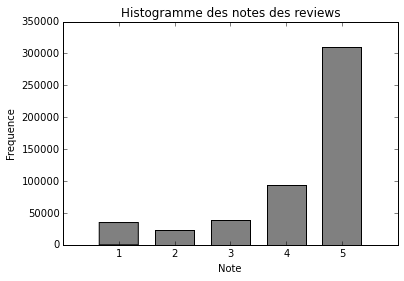

In [213]:
print(df["overall"].describe())
%matplotlib inline 
a=[int(i) for i in df["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Frequence");

Regardons la distribution des notes moyennes par produit. On constate que la distribution est moins "skewed" que précedemment.

            overall
count  83048.000000
mean       4.231570
std        0.983337
min        1.000000
25%        4.000000
50%        4.515877
75%        5.000000
max        5.000000


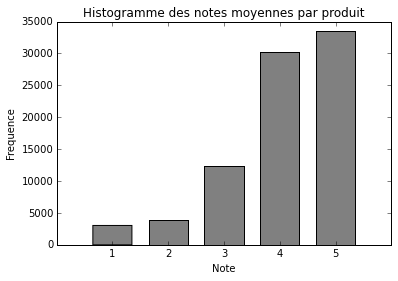

In [214]:
average_note_byproduct=df[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct.describe())
%matplotlib inline 
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes moyennes par produit");
plt.xlabel("Note");
plt.ylabel("Frequence");

Regardons la distribution du nombre de reviews par utilisateur.

                   0
count  339235.000000
mean        1.474444
std         2.342596
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       483.000000


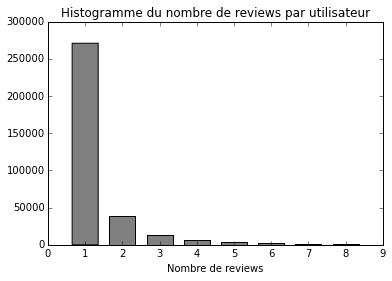

In [215]:
import collections
Nbreview_by_user=collections.Counter(df["reviewerID"])
print(pd.DataFrame(list(Nbreview_by_user.values())).describe())
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de reviews par utilisateur");
plt.xlabel("Nombre de reviews");
plt.ylabel("");

Définition de la fonction de comptage du nombre de mots d'une review

In [216]:
import re
def countWords(review):
    return (len(re.findall(r'\w+', review["reviewText"])))

In [217]:
df["countWordsReview"] = df.apply(countWords, axis = 1)

In [218]:
a = df["countWordsReview"]
print(max(a), min(a), stat.median(a), stat.mean(a))

6045 0 51 91.0517070752


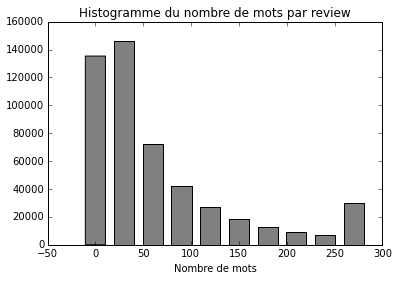

In [219]:
%matplotlib inline 
bins=range(0,330,30)
a = np.clip(df["countWordsReview"], 0, 300)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
##ax.set_xticks(bins[:-1])
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("");

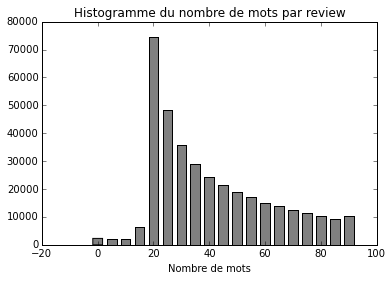

In [220]:
a = [s for s in df["countWordsReview"] if s < 101]
%matplotlib inline 
bins=range(0,100,5)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
##ax.set_xticks(bins[:-1])
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("");

In [15]:
#buf = StringIO()
#for i in range(df.shape[0]):
    #buf.write(df["reviewText"][i])

# Préparation des données

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
corpus=list(df_train["reviewText"])
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)
X_train_counts.shape

(400146, 219716)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
count_vect = CountVectorizer(stop_words= stopwords.words('english'))
X_train_counts = count_vect.fit_transform(corpus)
X_train_counts.shape

(400146, 219593)

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(400146, 219593)

# Machine Learning

In [45]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train.astype('category'))

In [46]:
corpus_test=list(df_test["reviewText"])
X_test_counts = count_vect.transform(corpus_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
predicted = clf.predict(X_test_tfidf)

In [47]:
from sklearn.linear_model import SGDClassifier
SGDclass=SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2=SGDclass.fit(X_train_tfidf, y_train.astype('category'))
predicted2 = clf2.predict(X_test_tfidf)

# Evaluation de la performance

In [48]:
np.mean(predicted == y_test)

0.62318941991463161

In [49]:
np.mean(predicted2 == y_test)

0.62278956785989181

In [53]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

             precision    recall  f1-score   support

        1.0       0.90      0.01      0.02      6932
        2.0       0.00      0.00      0.00      4495
        3.0       0.50      0.00      0.00      7728
        4.0       0.50      0.00      0.00     18610
        5.0       0.62      1.00      0.77     62272

avg / total       0.58      0.62      0.48    100037

[[   70     0     0     1  6861]
 [    4     0     0     1  4490]
 [    2     0     1     0  7725]
 [    0     0     0     6 18604]
 [    2     0     1     4 62265]]


D:\Users\acombess\PythonENSAE\python\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted2))
print(metrics.confusion_matrix(y_test, predicted2))

             precision    recall  f1-score   support

        1.0       0.86      0.00      0.01      6932
        2.0       0.00      0.00      0.00      4495
        3.0       0.00      0.00      0.00      7728
        4.0       0.00      0.00      0.00     18610
        5.0       0.62      1.00      0.77     62272

avg / total       0.45      0.62      0.48    100037

[[   30     0     0     0  6902]
 [    3     0     0     0  4492]
 [    2     0     0     0  7726]
 [    0     0     0     0 18610]
 [    0     0     0     0 62272]]


D:\Users\acombess\PythonENSAE\python\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Then: draw multi class ROC Curve using this example: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [198]:
for i in range(0,20) :
        print(str(corpus_test[i]) + "------ We predict "+ str(predicted[i]))

One Great Capo------ We predict 5.0
This product,and the seller are great!!------ We predict 5.0
Really nice!------ We predict 5.0
Very nice Mixer------ We predict 5.0
Could be a little tighter------ We predict 4.0
so far so good, but line-in doesn't really work------ We predict 5.0
High quality cello stand------ We predict 5.0
Returned for poor performance------ We predict 1.0
GLORIOUS DOMINGO------ We predict 5.0
Very Dark Blend------ We predict 5.0
3 different sets - all have 1 or 2 bad microphones------ We predict 5.0
Very best sound. The fit is very tight.------ We predict 5.0
The seller is a man of his word. Like New as he said------ We predict 5.0
Super cute------ We predict 5.0
Joey+Rory Inspired------ We predict 5.0
Great Christmas Gift------ We predict 5.0
Large and Sturdy------ We predict 5.0
Amazing sound------ We predict 5.0
Fantastic unit------ We predict 5.0
Unexpectedly Good!------ We predict 5.0


# Analyse de la performance en fonction du nombre de mots

In [255]:
def createBins(x):
    if x["countWordsSummary"] < 30:
        return(30)
    elif x["countWordsSummary"] < 100:
        return(100)
    elif x["countWordsSummary"] < 200:
        return(200)
    else:
        return(300)

In [256]:
dfy = pd.DataFrame(y_test)
dfy["predicted"] = predicted
dfy["reviewText"] = df_test["reviewText"]
dfy["countWordsReview"] = dfy.apply(countWords, axis = 1)
dfy["summary"] = df_test["summary"]
dfy["countWordsSummary"] = dfy.apply(countWords, axis = 1)
dfy["qualite"] = abs(predicted - y_test)
dfy["bin"] = dfy.apply(createBins, axis = 1)
dfy.head()

,overall,predicted,reviewText,countWordsReview,summary,countWordsSummary,qualite,bin
126863,5,5,I'm using this clamp to mount a ride cymbal on...,39,"Solid, great addition",39,0,100
393670,4,1,Pros - I bought a 12&#34; x 24&#34; Remo Mondo...,223,"A+ Superb Quality, 5 stars accept slightly sho...",223,3,300
376320,5,5,First off I want to note that these speakers a...,72,This really helps dialing in your mix,72,0,100
139913,5,5,.The ArRe-Se label appears to be Swiss or Fren...,166,Double-Gs...,166,0,200
383749,4,5,We bought this for our granddaughter and she l...,29,Karaoke Player,29,1,30


In [262]:
np.mean(dfy[dfy.bin==30]["qualite"])

0.7352659142878218

In [235]:
sum(abs(predicted - y_test))

58595.0

# Bits of useless code (so far)

In [36]:
#an example with another function TfidfVectorizer using frequency instead of count
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ["This is very strange",
          "This is very nice"]
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
print(dict(zip(vectorizer.get_feature_names(), idf)))

{'this': 1.0, 'is': 1.0, 'strange': 1.4054651081081644, 'very': 1.0, 'nice': 1.4054651081081644}


In [127]:
#Meh... Does not work yet
#nltk.download()
#all_words = nltk.FreqDist(w.lower() for w in nltk.word_tokenize(list(df["summary"]))) Does not work yet